In [ ]:
# library to download roboflow data
!pip install roboflow

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

# CAV Data and model loading

In [ ]:
# importing all required libraries.

from roboflow import Roboflow
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
import random
import pandas as pd

In [ ]:
api_key="DEox6oznQeGVSq8h49uK"
rf = Roboflow(api_key=api_key)
project = rf.workspace("school-ny3mt").project("hepsi-humo1")
# downloading the dataset from roboflow
dataset = project.version(2).download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to hepsi-2 in coco:: 100%|██████████| 2464/2464 [00:15<00:00, 162.35it/s]


In [ ]:
# defining the custom class and functions to load COCO dataset and annotations
class RoboDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels for each object
        labels = []
        for i in range(num_objs):
            # Map the coco category ID to the class index
            coco_category_id = coco_annotation[i]['category_id']
            labels.append(coco_category_id)

        labels = torch.as_tensor(labels, dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [ ]:
# transform function to convert images to Tensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [ ]:
# path to the image data and coco file
location_dir = './roadsigns-6'
location_dir = './hepsi-2'
#train_data_dir = dataset.location+'/train'
train_data_dir = location_dir +'/train'
#train_coco = dataset.location+'/train/_annotations.coco.json'
train_coco = location_dir +'/train/_annotations.coco.json'

# create the Dataset
robo_dataset = RoboDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 1

# defining the DataLoader
data_loader = torch.utils.data.DataLoader(robo_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=False,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [ ]:
# select device (whether GPU or CPU)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

# DataLoader is iterable over Dataset
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]

In [ ]:
# set False if there is a model already trained. or set True to train a new model.
# by defalut keep it False to load the pre trained model from directory.
is_training_on = True


In [ ]:
pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 4.9 MB/s eta 0:00:00


In [ ]:
from opacus import PrivacyEngine
# function to get the pre-trained object detection model.
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    model.to(device)
    return model


# dataset has 15 classes;
num_classes = 15
# feature to set how long the model should be trained.
num_epochs = 1
# get model instance.
model = get_model_instance_segmentation(num_classes)

if is_training_on:
  # model training
  # parameters
  params = [p for p in model.parameters() if p.requires_grad]
  # defining a stochastic gradient descent optimizer.
  optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, weight_decay=0.0005)

  len_dataloader = len(data_loader)

  for epoch in range(num_epochs):
      # turn on models training mode
      model.train()
      i = 0
      for imgs, annotations in data_loader:
          i += 1
          imgs = list(img.to(device) for img in imgs)
          annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
          if not (annotations[0]['boxes'].size()[0] == 0):
            loss_dict = model(imgs, annotations)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()
          print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}, Epoch: {epoch}')
else:
  # load model from directory.
  model.load_state_dict(torch.load('model2.pth'))

# move model to the right device
model.to(device)



Iteration: 1/242, Loss: 3.4783647060394287, Epoch: 0
Iteration: 2/242, Loss: 2.549750328063965, Epoch: 0
Iteration: 3/242, Loss: 1.0574315786361694, Epoch: 0
Iteration: 4/242, Loss: 0.8564581274986267, Epoch: 0
Iteration: 5/242, Loss: 0.9135135412216187, Epoch: 0
Iteration: 6/242, Loss: 1.0731747150421143, Epoch: 0
Iteration: 7/242, Loss: 0.460104763507843, Epoch: 0
Iteration: 8/242, Loss: 0.3451748490333557, Epoch: 0
Iteration: 9/242, Loss: 0.3806476593017578, Epoch: 0
Iteration: 10/242, Loss: 0.5711197853088379, Epoch: 0
Iteration: 11/242, Loss: 0.30523350834846497, Epoch: 0
Iteration: 12/242, Loss: 0.40752148628234863, Epoch: 0
Iteration: 13/242, Loss: 0.09700995683670044, Epoch: 0
Iteration: 14/242, Loss: 0.1995427906513214, Epoch: 0
Iteration: 15/242, Loss: 0.113660529255867, Epoch: 0
Iteration: 16/242, Loss: 0.0743873193860054, Epoch: 0
Iteration: 17/242, Loss: 0.27840372920036316, Epoch: 0
Iteration: 18/242, Loss: 0.534064769744873, Epoch: 0
Iteration: 19/242, Loss: 0.1588505804

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

# Model Evaluation and Evasion attack

In [ ]:
# define evasion attack method for object detection models
def fast_gradient_sign_method(model, imgs, labels, epsilon=0.15):
    # Determine prediction of the model
    # to enable loss calculation.
    model.train()
    # cloning the images with gradient enabled
    inp_imgs = imgs.clone().requires_grad_()
    # get the loss
    loss_dict = model(inp_imgs,labels)
    # make model backto prediction mode.
    model.eval()
    # calculating the loss.
    losses = sum(loss for loss in loss_dict.values())
    # updating the loss.
    losses.backward()
    # Update image to adversarial example as written above
    noise_grad = torch.sign(inp_imgs.grad.to(imgs.device))
    # add noise to the image.
    fake_imgs = imgs + epsilon * noise_grad
    # detach gradient
    fake_imgs.detach_()
    return fake_imgs, noise_grad

In [ ]:

location_dir = './hepsi-2'
test_data_dir = location_dir +'/valid'
test_coco = test_data_dir+'/_annotations.coco.json'

# create test Dataset
robo_dataset = RoboDataset(root=test_data_dir,
                          annotation=test_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
test_batch_size = 1

# DataLoader
data_loader = torch.utils.data.DataLoader(robo_dataset,
                                          batch_size=test_batch_size,
                                          shuffle=False,
                                          num_workers=2,
                                          collate_fn=collate_fn)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
imgs
i = 0
image_index = 100
# loding test data.
for imgs, annotations in data_loader:
  i += 10
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  # select random image of your preference. for example i choose 31. can be any number to break the loop up that point.
  if i == 100:
    break

# perform attack.
adversarials = fast_gradient_sign_method(model,imgs[0].unsqueeze(0),annotations,0.2)

In [ ]:
# Save the trained model to a file
torch.save(model.state_dict(), 'cnn_model.pth')

In [ ]:
# fetch advesarial image and noise.
adv_img,noise = adversarials

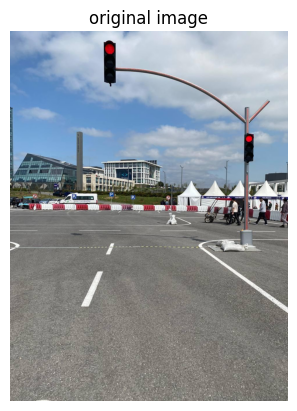

In [ ]:
# Plot the original image
plt.imshow(imgs[0].cpu().numpy().transpose(1, 2, 0))
plt.axis('off')
plt.title("original image")
plt.show()

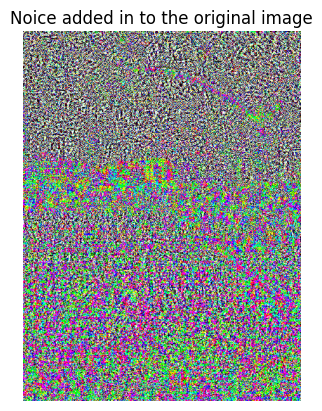

In [ ]:
# Plot the noise.
image_array = noise.cpu().numpy()

plt.imshow(image_array[0].transpose(1, 2, 0))
plt.axis('off')
plt.title("Noice added in to the original image")
plt.show()

In [ ]:
# predicting the model with pertubed image.
adv_pred = model(adv_img)
# prediction output
print(adv_pred)

[{'boxes': tensor([[5.2602e+02, 5.6566e+02, 5.7581e+02, 6.1498e+02],
        [8.0056e+02, 3.6565e+02, 8.4857e+02, 4.7683e+02],
        [5.4371e+02, 5.6347e+02, 5.7043e+02, 6.2546e+02],
        [5.3461e+02, 5.5563e+02, 5.6006e+02, 6.1924e+02],
        [7.9615e+02, 3.9298e+02, 8.4816e+02, 4.4820e+02],
        [3.3714e+02, 6.0066e+01, 3.6530e+02, 1.2984e+02],
        [3.2133e+02, 3.8324e+01, 3.7068e+02, 1.5556e+02],
        [2.5999e+02, 5.6427e+02, 3.0895e+02, 6.1604e+02],
        [3.2590e+02, 6.1128e+01, 3.7388e+02, 1.1183e+02],
        [7.9742e+02, 3.7189e+02, 8.4622e+02, 4.2523e+02],
        [5.2563e+02, 5.5829e+02, 5.5184e+02, 6.2405e+02],
        [2.7422e+02, 5.5450e+02, 3.0038e+02, 6.1992e+02],
        [2.6459e+02, 5.5371e+02, 2.9017e+02, 6.1944e+02],
        [6.7016e+02, 6.3802e+02, 7.1306e+02, 6.8625e+02],
        [7.8958e+02, 3.5910e+02, 8.6198e+02, 4.4586e+02],
        [2.8296e+02, 5.5589e+02, 3.0847e+02, 6.2074e+02],
        [5.2392e+02, 5.4106e+02, 5.7000e+02, 6.5345e+02],
   

In [ ]:
# predicting the model with original image
org_pred = model(imgs[0].unsqueeze(0))
#pred
print(org_pred)

[{'boxes': tensor([[7.9637e+02, 3.7194e+02, 8.5146e+02, 4.2583e+02],
        [8.0057e+02, 3.4681e+02, 8.4903e+02, 4.5926e+02],
        [3.2077e+02, 4.5394e+01, 3.7187e+02, 1.6220e+02],
        [7.9981e+02, 3.7041e+02, 8.5238e+02, 3.9945e+02],
        [8.0291e+02, 3.5896e+02, 8.3159e+02, 4.3046e+02],
        [8.1128e+02, 3.6380e+02, 8.4139e+02, 4.3356e+02],
        [7.9679e+02, 3.9283e+02, 8.5312e+02, 4.4657e+02],
        [3.2279e+02, 6.6548e+01, 3.7617e+02, 9.5516e+01],
        [3.1921e+02, 6.6314e+01, 3.7415e+02, 1.2150e+02],
        [7.9718e+02, 4.2572e+02, 8.4980e+02, 4.5511e+02],
        [7.9716e+02, 3.5467e+02, 8.4423e+02, 4.0886e+02],
        [7.9511e+02, 4.0180e+02, 8.4839e+02, 4.3128e+02],
        [3.2041e+02, 4.8931e+01, 3.7020e+02, 1.0486e+02],
        [3.1930e+02, 8.4428e+01, 3.7508e+02, 1.4035e+02],
        [3.3652e+02, 5.1786e+01, 3.6616e+02, 1.2362e+02],
        [7.7502e+02, 3.6388e+02, 8.6837e+02, 4.2345e+02],
        [3.1058e+02, 9.2544e+01, 3.8543e+02, 1.8202e+02],
   

In [ ]:
random.seed(0)

interval = 0.0025  # Desired interval between numbers
start = 0.1  # Starting value
end = 0.05  # Ending value

# Calculate the total number of intervals
num_intervals = int((end - start) / interval) + 1

# Generate the list of numbers
ep_values = [round(start + i * interval,4) for i in range(num_intervals)]

scores = []
labels = []
# attacking model with range of epsilon values.
for ep in ep_values:
  adv,noise = fast_gradient_sign_method(model,imgs[0].unsqueeze(0),annotations,ep)
  p = model(adv)
  scores.append(p[0]['scores'].detach().cpu().numpy())
  labels.append(p[0]['labels'].detach().cpu().numpy())

In [ ]:
import torch
import torchvision.transforms as transforms

def gaussian_blur(input_tensor, kernel_size=5, sigma=1.0):

    # Normalize input tensor to the range [0, 1]
    input_tensor = input_tensor.clamp(0, 1)

    # Define a GaussianBlur transformation
    gaussian_blur_transform = transforms.GaussianBlur(kernel_size, sigma)

    # Convert the input tensor to a PIL image
    input_pil_image = transforms.ToPILImage()(input_tensor.squeeze(0))

    # Apply the Gaussian blur transformation
    blurred_pil_image = gaussian_blur_transform(input_pil_image)

    # Convert the blurred PIL image back to a PyTorch tensor
    blurred_tensor = transforms.ToTensor()(blurred_pil_image)

    # Add back the batch dimension
    blurred_tensor = blurred_tensor.unsqueeze(0)

    return blurred_tensor




interval = 0.0025  # Desired interval between numbers
start = 0.0  # Starting value
end = 0.05  # Ending value

# Calculate the total number of intervals
num_intervals = int((end - start) / interval) + 1

# Generate the list of numbers
ep_values = [round(start + i * interval,4) for i in range(num_intervals)]

scores = []
labels = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# attacking model with range of epsilon values.
for ep in ep_values:
  adv,noise = fast_gradient_sign_method(model,imgs[0].unsqueeze(0),annotations,ep)
  blurred_image = gaussian_blur(adv)
  b = blurred_image.to(device)
  p = model(b)
  scores.append(p[0]['scores'].detach().cpu().numpy())
  labels.append(p[0]['labels'].detach().cpu().numpy())

In [ ]:
# combine results.
data = {'epsilon':ep_values, 'labels': labels, 'scores': scores}
# convert to data frame.
result = pd.DataFrame(data)
# display
display(result)

,epsilon,labels,scores
0,0.0000,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.49923941, 0.48452386, 0.45259503, 0.4076301..."
1,0.0025,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.492938, 0.4843466, 0.44664654, 0.40134835, ..."
2,0.0050,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.48180115, 0.48029107, 0.45122343, 0.4067812..."
3,0.0075,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.47836098, 0.47518855, 0.43146774, 0.4096186..."
4,0.0100,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.48516187, 0.47336158, 0.44504803, 0.3983225..."
5,0.0125,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.48084217, 0.45956594, 0.4342742, 0.41234824..."
6,0.0150,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.47062725, 0.45581847, 0.44889313, 0.4144928..."
7,0.0175,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.48524502, 0.46477067, 0.43709, 0.4350088, 0..."
8,0.0200,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.47498405, 0.4568914, 0.43872225, 0.4154218,..."
9,0.0225,"[13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 1...","[0.47734645, 0.4513489, 0.44077224, 0.4238758,..."


## Mesure efficiency

In [ ]:
def attack(imgs):

  epsilon = 0.02

  adv,noise = fast_gradient_sign_method(model,imgs[0].unsqueeze(0),annotations,ep)
  blurred_image = gaussian_blur(adv)
  b = blurred_image.to(device)
  adv_pred = model(b)
  org_pred = model(imgs[0].unsqueeze(0))
  return adv_pred[0]['labels'].detach().cpu().numpy()[0] != org_pred[0]['labels'].detach().cpu().numpy()[0]


imgs
i = 0
image_index = 100

attack_success_count = 0

for imgs, annotations in data_loader:
  i += 1
  imgs = list(img.to(device) for img in imgs)
  annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
  if attack(imgs):
    attack_success_count = attack_success_count + 1

  if i == 50:
    break

print("attack accuracy: ", attack_success_count/50)

attack accuracy:  0.28
